<a href="https://colab.research.google.com/github/zhus-dika/train_mars_rover-kinova_roboarm/blob/main/plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🐭 Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
import plotly.graph_objects as go
import gdown
import pandas as pd

## 🐒 Determine routes

In [ ]:
offsets = {
    "forward":  (0, 1),
    "backward": (0, -1),
    "right":    (1, 0),
    "left":     (-1, 0),
    "forward-right":  (1, 1),
    "forward-left":   (-1, 1),
    "backward-right": (1, -1),
    "backward-left":  (-1, -1),
}

opposites = {
    "forward": "backward",
    "backward": "forward",
    "left": "right",
    "right": "left",
    "forward-left": "backward-right",
    "backward-right": "forward-left",
    "forward-right": "backward-left",
    "backward-left": "forward-right"
}

## 🦚 Construct route

In [ ]:
full_starts = [(8, 70), (48, 61), (23, 44), (66, 74), (58, 29), (19, 31), (37, 50), (60, 55), (69, 47), (12, 55), (20, 60), (31, 71), (11, 65), (5, 85)]
full_directions = []

### 🦤 Route

In [ ]:
def reverse_directions(directions):
    """Разворачивает маршрут в обратную сторону с заменой направлений"""


    reversed_list = []
    for direction in reversed(directions):
        if direction not in opposites:
            raise ValueError(f"Неизвестное направление: {direction}")
        reversed_list.append(opposites[direction])

    return reversed_list

In [ ]:
directions = ["backward", "backward", "backward", "backward", "backward", "backward-right",   "backward-right", "right","right","right", "forward-right", "forward-right", "forward-right",
              "forward-right", "forward-right", "forward-right", "forward-right", "forward-right", "forward-right", "forward-right", "right", "right", "right", "right", "right","backward-right", "backward-right",
              "backward", "backward", "backward", "backward-left", "backward-left",  "backward-left", "backward-left",  "backward-left", "backward-left", "backward-left" , "backward", "backward", "backward","backward",
              "backward-left",  "backward-left", "backward-left",  "backward-left", "backward", "backward", "backward", "backward", "backward-left", "backward-left", "left", "left"]

In [ ]:
def build_route(start, directions_list):
    route = [start]
    for move in directions_list:
        if move not in offsets:
            continue
        di, dj = offsets[move]
        i, j = route[-1]
        ni, nj = i + di, j + dj
        if 0 <= ni < 100 and 0 <= nj < 100:
            route.append((ni, nj))
        else:
            break
    return route

### 🦣 Check route for correctness

In [ ]:
def check_route(directions):

    # Проверка на противоречия
    conflicts = []
    for i in range(len(directions) - 1):
        current = directions[i]
        next_ = directions[i + 1]
        if current in opposites and opposites[current] == next_:
            conflicts.append((i, current, next_))

    # Результат
    if conflicts:
        print("❗ Найдены противоречивые переходы:")
        for idx, d1, d2 in conflicts:
            print(f"  {idx}: {d1} → {d2}")
    else:
        print("✅ Противоречий не обнаружено.")

In [ ]:
check_route(directions)

✅ Противоречий не обнаружено.


### 🐀 Combine all routes

In [ ]:
all_routes = [build_route(start, directions) for start in full_starts]

# Инвертируем направления
reversed_directions = [opposites[d] for d in reversed(directions)]

# Все реверсные маршруты
all_reversed_routes = [build_route(route[-1], reversed_directions) for route in all_routes]

# Объединение всех маршрутов
all_combined_routes = all_routes + all_reversed_routes

# Проверка результата
print(f"✅ Построено маршрутов: {len(all_combined_routes)}")
print("Пример маршрута:", all_combined_routes[0][:5])

✅ Построено маршрутов: 28
Пример маршрута: [(8, 70), (8, 69), (8, 68), (8, 67), (8, 66)]


### 🐣 Plot new route

In [ ]:
# === Загрузка рельефа (для координат Xg, Yg) ===
mat = scipy.io.loadmat("mars_terrain_grid.mat")
terrain = mat["mars_terrain_grid"]
xg = terrain["xg"][0, 0].flatten()
yg = terrain["yg"][0, 0].flatten()

# === Функция: индексы (i,j) → (x,y)
def route_to_xy(route):
    x = [xg[i] for i, j in route]
    y = [yg[j] for i, j in route]
    return x, y

# === Построение маршрутов (предполагается, что all_combined_routes уже есть)
route_traces = []
for idx, route in enumerate(all_combined_routes):
    x, y = route_to_xy(route)
    trace = go.Scatter(
        x=x,
        y=y,
        mode='lines+markers',
        name=f'Route {idx+1}',
        line=dict(width=2),
        marker=dict(size=4)
    )
    route_traces.append(trace)

# === Финальный интерактивный график
fig = go.Figure(data=route_traces)

fig.update_layout(
    title="📍 Маршруты на плоскости X–Y",
    xaxis_title="X",
    yaxis_title="Y",
    xaxis=dict(scaleanchor="y", scaleratio=1),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    height=700
)

fig.show()


## 🦎 Plot route

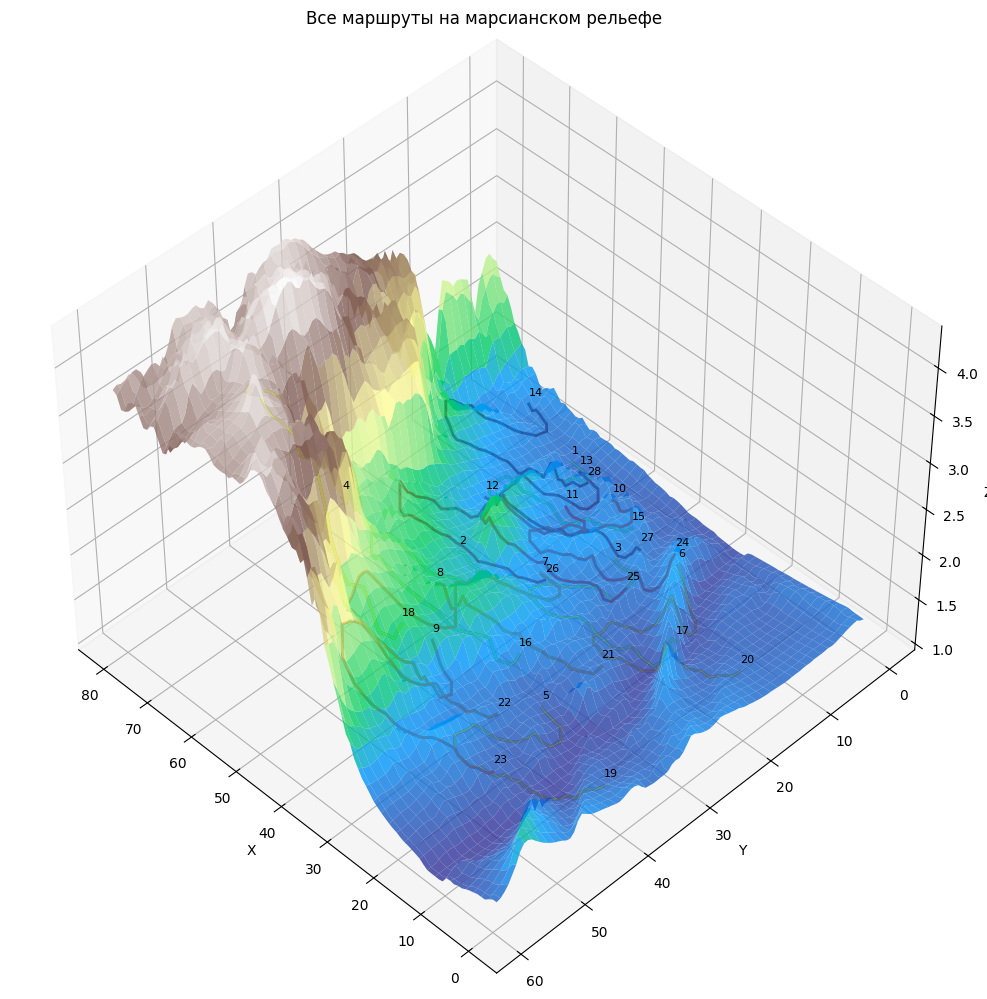

In [ ]:
# === Загрузка поверхности ===
mat = scipy.io.loadmat("mars_terrain_grid.mat")
terrain = mat["mars_terrain_grid"]
xg = terrain["xg"][0, 0].flatten()
yg = terrain["yg"][0, 0].flatten()
zg = terrain["z_heights"][0, 0]
Xg, Yg = np.meshgrid(xg, yg)
Z = zg.T

# === Перевод маршрута в координаты ===
def route_to_xyz(route):
    x = [xg[j] for i, j in route]
    y = [yg[i] for i, j in route]
    z = [Z[i, j] for i, j in route]
    return x, y, z

# === all_combined_routes должен быть определён заранее ===
# Предположим, что он уже существует из предыдущего шага

# === Построение 3D графика ===
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xg, Yg, Z, cmap='terrain', alpha=0.8, edgecolor='none')

# Цвета маршрутов
colors = plt.cm.jet(np.linspace(0, 1, len(all_combined_routes)))

# Добавляем маршруты
for idx, route in enumerate(all_combined_routes):
    x, y, z = route_to_xyz(route)
    ax.plot(x, y, z, color=colors[idx], linewidth=2, label=f'Route {idx+1}')
    ax.text(x[0], y[0], z[0] + 0.1, f'{idx+1}', fontsize=8, color='black')

# Оформление
ax.set_title("Все маршруты на марсианском рельефе")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=45, azim=135)
plt.tight_layout()
plt.show()

In [ ]:
# === Загрузка рельефа ===
mat = scipy.io.loadmat("mars_terrain_grid.mat")
terrain = mat["mars_terrain_grid"]
xg = terrain["xg"][0, 0].flatten()
yg = terrain["yg"][0, 0].flatten()
zg = terrain["z_heights"][0, 0]
X, Y = np.meshgrid(xg, yg)
Z = zg.T  # ориентация для plot_surface

# === Функция преобразования маршрута (i, j) → (x, y, z)
def route_to_xyz(route):
    x = [xg[j] for i, j in route]
    y = [yg[i] for i, j in route]
    z = [Z[i, j] for i, j in route]
    return x, y, z

# === Создание поверхности рельефа ===
terrain_surface = go.Surface(
    x=X,
    y=Y,
    z=Z,
    colorscale='Earth',
    showscale=False,
    opacity=0.85,
    name='terrain'
)

# === Маршруты (all_combined_routes должен быть заранее создан)
route_traces = []
for idx, route in enumerate(all_combined_routes):
    x, y, z = route_to_xyz(route)
    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines+markers',
        name=f'Route {idx+1}',
        line=dict(width=4),
        marker=dict(size=3)
    )
    route_traces.append(trace)

# === Финальный график
fig = go.Figure(data=[terrain_surface] + route_traces)

fig.update_layout(
    title="🚀 Все маршруты на 3D-поверхности марсианского рельефа",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=True
)

fig.show()

## 🐸 Calculate yaw, pitch, roll and save data to .mat file

In [ ]:
#https://docs.google.com/spreadsheets/d/1wLSmGAILQmGg6tuUFifICRNLyW2WyYnZtWtbB9TXBes/edit?usp=sharing

url_excel_file = "https://docs.google.com/uc?id=1wLSmGAILQmGg6tuUFifICRNLyW2WyYnZtWtbB9TXBes"
excel_file = "calc_values.xlsx"
gdown.download(url_excel_file, excel_file, quiet=False);

df_calc_values = pd.read_excel(excel_file, index_col=0)
df_calc_values

Downloading...
From (original): https://docs.google.com/uc?id=1wLSmGAILQmGg6tuUFifICRNLyW2WyYnZtWtbB9TXBes
From (redirected): https://docs.google.com/spreadsheets/d/1wLSmGAILQmGg6tuUFifICRNLyW2WyYnZtWtbB9TXBes/export?format=xlsx
To: /content/calc_values.xlsx
6.32kB [00:00, 754kB/s]


,pitch,roll,delta_pzOffset
idx,,,
1,0.000,-0.010,0.515
2,0.010,-0.020,0.490
3,0.010,0.010,0.530
4,0.070,-0.110,0.310
5,0.020,-0.015,0.550
6,0.070,-0.100,0.930
7,0.018,-0.030,0.500
8,-0.010,-0.045,0.700
9,0.031,0.000,0.770


In [ ]:
# Предполагается, что all_combined_routes уже определён и содержит (i, j)
# Также файл mars_terrain_grid.mat должен быть в директории

# === Загрузка координат рельефа ===
mat = scipy.io.loadmat("mars_terrain_grid.mat")
terrain = mat["mars_terrain_grid"]
xg = terrain["xg"][0, 0].flatten()
yg = terrain["yg"][0, 0].flatten()
zg = terrain["z_heights"][0, 0]
Z = zg.T  # высоты


# === Формирование списка rover_path структур ===
paths_dict = {}
for idx, route in enumerate(all_combined_routes):
    x = np.array([xg[j] for i, j in route])
    y = np.array([yg[i] for i, j in route])
    z = np.array([Z[i, j] for i, j in route])

    print(idx, z[idx]+df_calc_values.loc[idx + 1, 'delta_pzOffset'])
    rover_path = {
        'x': x.reshape(-1, 1),
        'y': y.reshape(-1, 1),
        'z': z.reshape(-1, 1),
        'Offset_vis_z': 0.05,
        'name': f'rover_path_{idx+1}',
        't0': {
            'yaw': np.pi,
            'pitch': df_calc_values.loc[idx + 1, 'pitch'],
            'roll': df_calc_values.loc[idx + 1, 'roll'],
            'pzOffset': z[idx] + df_calc_values.loc[idx + 1, 'delta_pzOffset']
        }
    }
    if idx >= len(all_combined_routes) / 2:
        rover_path['t0']['yaw'] = np.pi / 2
    paths_dict[f'rover_path_{idx+1}'] = rover_path

# === Сохраняем в файл ===
scipy.io.savemat("rover_paths.mat", paths_dict)

print("✅ Сохранено:", len(paths_dict), "маршрутов в rover_paths.mat")

0 1.7460273852131696
1 2.1542125454530154
2 1.8235169358158168
3 3.0026729019707967
4 1.6649242190811913
5 1.986326938918174
6 1.9138000617771158
7 2.324224169032309
8 2.1782274635535726
9 1.8625452464945857
10 1.8603196648477163
11 1.9995344059740265
12 1.8396245169052947
13 1.880992351972727
14 1.8698874214063343
15 1.8755052955055451
16 1.7987756066120892
17 2.399392538436297
18 1.726052954610563
19 1.731439635672071
20 1.7372674074290015
21 1.7714258071887412
22 1.6886991958848137
23 1.9769631726417587
24 1.7973675899641566
25 1.9122323783821036
26 1.819217587790269
27 1.8324267486624894
✅ Сохранено: 28 маршрутов в rover_paths.mat
